In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, root_scalar
from scipy.special import comb
import pandas as pd
from dataclasses import dataclass
from typing import Tuple, List, Callable
import warnings
warnings.filterwarnings('ignore')

try:
    from IPython import get_ipython
    ipython = get_ipython()
    if ipython is not None:
        ipython.run_line_magic('matplotlib', 'inline')
except:
    pass


plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10

@dataclass
class ContestParameters:
    """Parameters for the innovation contest model"""
    N: int  # Number of potential agents
    V: float  # Total prize budget
    c: float  # Entry cost
    a: float  # Lower bound of efficiency distribution
    b: float  # Upper bound of efficiency distribution
    d: float  # Diversity cover idea 

    def __post_init__(self):
        """Validate parameters"""
        if self.N <= 0:
            raise ValueError("N must be positive")
        if self.V <= 0:
            raise ValueError("V must be positive")
        if self.c <= 0:
            raise ValueError("c must be positive")
        if self.a >= self.b:
            raise ValueError("a must be less than b")
        if self.d < 0:
            raise ValueError("d must be non-negative")

class InnovationContest:
    """
    Innovation Contest Model with Multiple Prizes and Idea Diversity
    Based on Chen, Chen, Huang & Liu (2024)
    """

    def __init__(self, params: ContestParameters):
        self.params = params
        self.N = params.N
        self.V = params.V
        self.c = params.c
        self.a = params.a
        self.b = params.b
        self.d = params.d

    def F(self, t: float) -> float:
        """CDF of uniform distribution on [a, b]"""
        if t < self.a:
            return 0.0
        elif t > self.b:
            return 1.0
        else:
            return (t - self.a) / (self.b - self.a)

    def f(self, t: float) -> float:
        """PDF of uniform distribution on [a, b]"""
        if self.a <= t <= self.b:
            return 1.0 / (self.b - self.a)
        else:
            return 0.0

    def J(self, t: float) -> float:
        """Virtual efficiency function J(t) = t - (1-F(t))/f(t)"""
        if self.a <= t <= self.b:
            f_t = self.f(t)
            if f_t > 1e-10:  # avoid/0
                return t - (1 - self.F(t)) / f_t
            else:
                return t
        else:
            return 0.0

    def G(self, t: float, tc: float) -> float:
        """Truncated CDF G(t, tc) = (F(t) - F(tc)) / (1 - F(tc))"""
        if tc >= self.b:
            return 0.0
        if t <= tc:
            return 0.0
        elif t >= self.b:
            return 1.0
        else:
            denom = 1 - self.F(tc)
            if denom < 1e-10:  # avoiding/0
                return 0.0
            return (self.F(t) - self.F(tc)) / denom

    def g(self, t: float, tc: float) -> float:
        """Truncated PDF g(t, tc) = f(t) / (1 - F(tc))"""
        if tc >= self.b:
            return 0.0
        if self.a <= t <= self.b and t >= tc:
            denom = 1 - self.F(tc)
            if denom < 1e-10:  # avoiding/0
                return 0.0
            return self.f(t) / denom
        else:
            return 0.0

    def pn(self, tc: float, n: int) -> float:
        """
        Probability of exactly n-1 rivals entering
        pn(tc) = C(N-1, n-1) * (1-F(tc))^(n-1) * F(tc)^(N-n)
        """
        if n < 1 or n > self.N:
            return 0.0

        try:
            prob_enter = 1 - self.F(tc)
            prob_not_enter = self.F(tc)

            # avoiding low
            if prob_enter < 1e-10:
                return 0.0 if n > 1 else 1.0
            if prob_not_enter < 1e-10:
                return 1.0 if n == self.N else 0.0

            return comb(self.N-1, n-1, exact=True) * \
                   prob_enter**(n-1) * prob_not_enter**(self.N - n)
        except:
            return 0.0

    def V_n(self, t: float, n: int, prizes: np.ndarray, tc: float) -> float:
        """
        Expected prize for type t in scenario n
        V^(n)(t) = Σ[j=1 to n] v_{n+1-j} * C(n-1, j-1) * G^(j-1) * (1-G)^(n-j)
        """
        if n > len(prizes) or n <= 0:
            return 0.0

        expected_prize = 0.0
        G_t = self.G(t, tc)

        for j in range(1, n + 1):
            prize_index = n - j  # v_{n+1-j} corresponds to prizes[n-j]
            if prize_index < len(prizes):
                try:
                    coef = comb(n-1, j-1, exact=True)
                    # 避免数值问题
                    if G_t < 1e-10 and j > 1:
                        prob = 0.0
                    elif G_t > 1 - 1e-10 and j < n:
                        prob = 0.0
                    else:
                        prob = G_t**(j-1) * (1 - G_t)**(n-j)
                    expected_prize += prizes[prize_index] * coef * prob
                except:
                    continue

        return expected_prize

    def effort(self, t: float, n: int, prizes: np.ndarray, tc: float,
               num_points: int = 100) -> float:
        """
        Equilibrium effort function e^(n)(t, W_n, tc)
        e^(n)(t) = t*V^(n)(t) - ∫[tc to t] V^(n)(s)ds - tc*vn
        """
        if t < tc or t < self.a or t > self.b:
            return 0.0

        if abs(t - tc) < 1e-10:  # t ≈ tc
            return 0.0

        # Calculate integral using trapezoidal 
        s_values = np.linspace(tc, t, num_points)
        V_values = np.array([self.V_n(s, n, prizes, tc) for s in s_values])
        integral = np.trapezoid(V_values, s_values)

        vn = prizes[n-1] if n <= len(prizes) else 0.0
        effort_value = t * self.V_n(t, n, prizes, tc) - integral - tc * vn

        return max(0.0, effort_value)

    def g_order_stat(self, t: float, j: int, n: int, tc: float) -> float:
        """
        Density of j-th order statistic in scenario n
        g_{j,n}(t, tc) = n * C(n-1, j-1) * G^(j-1) * (1-G)^(n-j) * g(t, tc)
        """
        if j < 1 or j > n or t < tc:
            return 0.0

        try:
            G_t = self.G(t, tc)
            g_t = self.g(t, tc)
            coef = n * comb(n-1, j-1, exact=True)

            return coef * G_t**(j-1) * (1 - G_t)**(n-j) * g_t
        except:
            return 0.0

    def total_effort_scenario_n(self, n: int, prizes: np.ndarray, tc: float,
                                num_points: int = 100) -> float:
        """
        Total effort in scenario n: TE^(n)(v, tc)
        TE^(n) = n * ∫[tc to b] J(t) * V^(n)(t) * g(t, tc) dt - n*tc*vn
        """
        if tc >= self.b:
            return 0.0

        t_values = np.linspace(tc, self.b, num_points)
        integrand = np.zeros(num_points)

        for i, t in enumerate(t_values):
            integrand[i] = self.J(t) * self.V_n(t, n, prizes, tc) * self.g(t, tc)

        integral = np.trapz(integrand, t_values)
        vn = prizes[n-1] if n <= len(prizes) else 0.0

        return n * integral - n * tc * vn

    def total_effort(self, prizes: np.ndarray, tc: float) -> float:
        """
        Expected total effort across all scenarios: TE(v, tc)
        TE(v, tc) = Σ[n=1 to N] C(N,n) * (1-F(tc))^n * F(tc)^(N-n) * TE^(n)(v, tc)
        """
        total = 0.0

        for n in range(1, self.N + 1):
            try:
                prob = comb(self.N, n, exact=True) * \
                       (1 - self.F(tc))**n * self.F(tc)**(self.N - n)
                te_n = self.total_effort_scenario_n(n, prizes, tc)
                total += prob * te_n
            except:
                continue

        return total

    def value_diverse_ideas(self, tc: float) -> float:
        """
        Value of diverse ideas: N * (1 - F(tc)) * d / 2
        """
        return self.N * (1 - self.F(tc)) * self.d / 2

    def organizer_payoff(self, prizes: np.ndarray, tc: float) -> float:
        """
        Organizer's objective function: P(v, tc; d)
        P = TE(v, tc) + N * (1 - F(tc)) * d / 2
        """
        te = self.total_effort(prizes, tc)
        value_ideas = self.value_diverse_ideas(tc)
        return te + value_ideas

    def participation_constraint(self, prizes: np.ndarray, tc: float) -> float:
        """
        Participation constraint: Σ[n=1 to N] pn(tc) * vn = c
        Returns the difference (should be 0 at equilibrium)
        """
        lhs = sum(self.pn(tc, n) * prizes[n-1]
                  for n in range(1, min(len(prizes) + 1, self.N + 1)))
        return lhs - self.c

    def find_entry_threshold(self, prizes: np.ndarray,
                            tc_init: float = None) -> float:
        """
        Find entry threshold tc that satisfies participation constraint
        """
        if tc_init is None:
            tc_init = (self.a + self.b) / 2

        def constraint_func(tc):
            return self.participation_constraint(prizes, tc)

        try:
            # try brentq
            sol = root_scalar(constraint_func, bracket=[self.a, self.b-1e-6],
                            method='brentq', xtol=1e-8)
            return sol.root
        except:
            # if fail,try other way return begining
            try:
                sol = root_scalar(constraint_func, x0=tc_init, x1=tc_init*1.1,
                                method='secant')
                if self.a <= sol.root <= self.b:
                    return sol.root
            except:
                pass
            return tc_init

    def winner_take_all_threshold(self) -> float:
        """
        Entry threshold for winner-take-all: t1 = F^{-1}((c/V)^(1/(N-1)))
        """
        if self.N == 1:
            return self.a

        try:
            F_inv_arg = (self.c / self.V)**(1/(self.N - 1))
            # For uniform distribution: F^{-1}(x) = a + x * (b - a)
            t1 = self.a + F_inv_arg * (self.b - self.a)
            return min(max(t1, self.a), self.b)
        except:
            return (self.a + self.b) / 2

    def simulate_contest(self, prizes: np.ndarray, num_simulations: int = 1000) -> dict:
        """
        Simulate the contest with given prize structure
        """
        tc = self.find_entry_threshold(prizes)

        results = {
            'entry_decisions': [],
            'efforts': [],
            'ideas': [],
            'total_values': [],
            'rankings': [],
            'prize_allocations': []
        }

        for _ in range(num_simulations):
            # Draw types and ideas
            types = np.random.uniform(self.a, self.b, self.N)
            ideas = np.random.uniform(0, self.d, self.N)

            # Entry decisions
            enter = types >= tc
            entrants = np.where(enter)[0]
            n_entrants = len(entrants)

            if n_entrants == 0:
                continue

            # Calculate e for entrants
            efforts = np.zeros(self.N)
            for idx in entrants:
                t = types[idx]
                effort_val = self.effort(t, n_entrants, prizes, tc)
                efforts[idx] = effort_val

            # Calculate total values (e + idea)
            total_vals = efforts + ideas

            # Ranking based on e (not ideas, as per model)
            ranking = np.argsort(-efforts)  # Descending order

            # Prize allocation
            prize_alloc = np.zeros(self.N)
            for rank, idx in enumerate(ranking):
                if enter[idx] and rank < len(prizes):
                    prize_alloc[idx] = prizes[rank]

            results['entry_decisions'].append(enter)
            results['efforts'].append(efforts)
            results['ideas'].append(ideas)
            results['total_values'].append(total_vals)
            results['rankings'].append(ranking)
            results['prize_allocations'].append(prize_alloc)

        # Aggregate statistics
        if len(results['entry_decisions']) > 0:
            results['entry_threshold'] = tc
            results['avg_num_entrants'] = np.mean([np.sum(e) for e in results['entry_decisions']])
            results['avg_total_effort'] = np.mean([np.sum(e) for e in results['efforts']])
            results['avg_total_value'] = np.mean([np.sum(v) for v in results['total_values']])
            results['theoretical_te'] = self.total_effort(prizes, tc)
            results['theoretical_payoff'] = self.organizer_payoff(prizes, tc)
        else:
            results['entry_threshold'] = tc
            results['avg_num_entrants'] = 0
            results['avg_total_effort'] = 0
            results['avg_total_value'] = 0
            results['theoretical_te'] = 0
            results['theoretical_payoff'] = 0

        return results

    def optimal_two_prize(self, num_points: int = 50) -> Tuple[np.ndarray, float]:
        """
        Find optimal prize structure with at most two prizes
        Searches over v1 ∈ [V/2, V] and sets v2 = V - v1
        """
        best_payoff = -np.inf
        best_v1 = self.V
        best_tc = self.winner_take_all_threshold()

        v1_range = np.linspace(self.V/2, self.V, num_points)

        for v1 in v1_range:
            v2 = self.V - v1
            prizes = np.array([v1, v2] + [0.0] * (self.N - 2))

            try:
                tc = self.find_entry_threshold(prizes)
                payoff = self.organizer_payoff(prizes, tc)

                if payoff > best_payoff:
                    best_payoff = payoff
                    best_v1 = v1
                    best_tc = tc
            except:
                continue

        best_v2 = self.V - best_v1
        optimal_prizes = np.array([best_v1, best_v2] + [0.0] * (self.N - 2))

        return optimal_prizes, best_tc

    def compare_prize_structures(self, prize_structures: dict) -> pd.DataFrame:
        """
        Compare different prize structures
        """
        results = []

        for name, prizes in prize_structures.items():
            try:
                tc = self.find_entry_threshold(prizes)
                te = self.total_effort(prizes, tc)
                payoff = self.organizer_payoff(prizes, tc)

                # Gini coefficient of prizes
                sorted_prizes = np.sort(prizes)[::-1]
                n = len(sorted_prizes)
                cumsum = np.cumsum(sorted_prizes)
                total = np.sum(sorted_prizes)
                if total > 0:
                    gini = (n + 1 - 2 * np.sum(cumsum) / total) / n
                else:
                    gini = 0.0

                results.append({
                    'Prize Structure': name,
                    'Entry Threshold': tc,
                    'Entry Probability': 1 - self.F(tc),
                    'Total Effort': te,
                    'Value of Ideas': self.value_diverse_ideas(tc),
                    'Organizer Payoff': payoff,
                    'Prize 1': prizes[0],
                    'Prize 2': prizes[1] if len(prizes) > 1 else 0,
                    'Gini Coefficient': gini,
                    'Budget Used': np.sum(prizes)
                })
            except Exception as e:
                print(f"Warning: Error processing {name}: {e}")
                continue

        return pd.DataFrame(results)



In [2]:
def run_comprehensive_simulation():
    """
    Run comprehensive simulations matching the paper's examples
    """
    print("=" * 80)
    print("Innovation Contest Simulation")
    print("Multiple Prizes and Idea Diversity")
    print("=" * 80)

    # Base parameters (matching paper's examples)
    params = ContestParameters(
        N=5,
        V=0.01,
        c=0.001,
        a=0.0,
        b=1.0,
        d=0.0  # Will vary this
    )

    contest = InnovationContest(params)

    # Test 1: Winner-take-all vs Multiple Prizes with low diversity
    print("\n" + "=" * 80)
    print("Test 1: Low Diversity (d = 2/15 = 0.133)")
    print("=" * 80)

    contest.d = 2/15

    prize_structures = {
        'Winner-Take-All': np.array([0.01, 0, 0, 0, 0]),
        'Two Equal Prizes': np.array([0.005, 0.005, 0, 0, 0]),
        'Three Equal Prizes': np.array([0.01/3, 0.01/3, 0.01/3, 0, 0]),
        'Decreasing Prizes': np.array([0.005, 0.003, 0.002, 0, 0])
    }

    results_low = contest.compare_prize_structures(prize_structures)
    print("\n", results_low.to_string(index=False))

    # Test 2: Winner-take-all vs Multiple Prizes with high diversity
    print("\n" + "=" * 80)
    print("Test 2: High Diversity (d = 2/5 = 0.4)")
    print("=" * 80)

    contest.d = 2/5

    results_high = contest.compare_prize_structures(prize_structures)
    print("\n", results_high.to_string(index=False))

    # Test 3: Optimal two-prize structure across diversity levels
    print("\n" + "=" * 80)
    print("Test 3: Optimal Two-Prize Structure vs Diversity")
    print("=" * 80)

    d_values = np.linspace(0, 0.6, 13)
    optimal_results = []

    print("Computing optimal prizes for different diversity levels...")
    for i, d in enumerate(d_values):
        print(f"  Progress: {i+1}/{len(d_values)}", end='\r')
        contest.d = d
        optimal_prizes, tc = contest.optimal_two_prize(num_points=30)
        payoff = contest.organizer_payoff(optimal_prizes, tc)

        # Winner-take-all for comparison
        wta_prizes = np.array([contest.V] + [0.0] * (contest.N - 1))
        tc_wta = contest.find_entry_threshold(wta_prizes)
        payoff_wta = contest.organizer_payoff(wta_prizes, tc_wta)

        optimal_results.append({
            'Diversity (d)': d,
            'Optimal v1': optimal_prizes[0],
            'Optimal v2': optimal_prizes[1],
            'v2/V Ratio': optimal_prizes[1] / contest.V,
            'Entry Threshold': tc,
            'Optimal Payoff': payoff,
            'WTA Payoff': payoff_wta,
            'Advantage': payoff - payoff_wta
        })
    print()  # New line after progress

    df_optimal = pd.DataFrame(optimal_results)
    print("\n", df_optimal.to_string(index=False))

    # Test 4: Monte Carlo Simulation
    print("\n" + "=" * 80)
    print("Test 4: Monte Carlo Simulation (d = 0.4, N=5)")
    print("=" * 80)

    contest.d = 0.4

    # Winner-take-all
    print("Running Monte Carlo simulation for Winner-Take-All...")
    wta_prizes = np.array([contest.V] + [0.0] * (contest.N - 1))
    sim_wta = contest.simulate_contest(wta_prizes, num_simulations=1000)

    # Equal prizes
    print("Running Monte Carlo simulation for Equal Prizes...")
    equal_prizes = np.array([contest.V / contest.N] * contest.N)
    sim_equal = contest.simulate_contest(equal_prizes, num_simulations=1000)

    print("\nWinner-Take-All:")
    print(f"  Entry Threshold: {sim_wta['entry_threshold']:.4f}")
    print(f"  Avg # Entrants: {sim_wta['avg_num_entrants']:.2f}")
    print(f"  Avg Total Effort (Simulated): {sim_wta['avg_total_effort']:.6f}")
    print(f"  Theoretical Total Effort: {sim_wta['theoretical_te']:.6f}")
    print(f"  Theoretical Payoff: {sim_wta['theoretical_payoff']:.6f}")

    print("\nEqual Prizes:")
    print(f"  Entry Threshold: {sim_equal['entry_threshold']:.4f}")
    print(f"  Avg # Entrants: {sim_equal['avg_num_entrants']:.2f}")
    print(f"  Avg Total Effort (Simulated): {sim_equal['avg_total_effort']:.6f}")
    print(f"  Theoretical Total Effort: {sim_equal['theoretical_te']:.6f}")
    print(f"  Theoretical Payoff: {sim_equal['theoretical_payoff']:.6f}")


    print("\nCreating visualizations...")
    create_visualizations(contest, d_values, df_optimal, results_low, results_high)

    return df_optimal, results_low, results_high



In [3]:
def create_visualizations(contest, d_values, df_optimal, results_low, results_high):
    """
    Create visualizations matching the paper's figures
    """
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Innovation Contest Analysis', fontsize=16, fontweight='bold')

    # Plot 1: Optimal first prize vs diversity
    ax = axes[0, 0]
    ax.plot(df_optimal['Diversity (d)'], df_optimal['Optimal v1'], 'b-', linewidth=2, label='Optimal v₁')
    ax.axhline(y=contest.V, color='r', linestyle='--', linewidth=1.5, label='Winner-Take-All')
    ax.axhline(y=contest.V/2, color='g', linestyle='--', linewidth=1.5, label='Equal Split')
    ax.set_xlabel('Diversity (d)', fontsize=12)
    ax.set_ylabel('Optimal First Prize v₁', fontsize=12)
    ax.set_title('Optimal First Prize vs Idea Diversity', fontsize=13, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

    # Plot 2: Second prize ratio vs diversity
    ax = axes[0, 1]
    ax.plot(df_optimal['Diversity (d)'], df_optimal['v2/V Ratio'], 'g-', linewidth=2)
    ax.set_xlabel('Diversity (d)', fontsize=12)
    ax.set_ylabel('Second Prize / Budget Ratio', fontsize=12)
    ax.set_title('Prize Equality vs Idea Diversity', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_ylim(bottom=0)

    # Plot 3: Entry threshold vs diversity
    ax = axes[0, 2]
    ax.plot(df_optimal['Diversity (d)'], df_optimal['Entry Threshold'], 'r-', linewidth=2)
    ax.set_xlabel('Diversity (d)', fontsize=12)
    ax.set_ylabel('Entry Threshold', fontsize=12)
    ax.set_title('Entry Threshold vs Idea Diversity', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3)

    # Plot 4: Payoff advantage of optimal vs WTA
    ax = axes[1, 0]
    ax.plot(df_optimal['Diversity (d)'], df_optimal['Advantage'], 'purple', linewidth=2)
    ax.axhline(y=0, color='k', linestyle='-', linewidth=0.8)
    ax.fill_between(df_optimal['Diversity (d)'], 0, df_optimal['Advantage'],
                     where=df_optimal['Advantage']>=0, alpha=0.3, color='green', label='Advantage')
    ax.set_xlabel('Diversity (d)', fontsize=12)
    ax.set_ylabel('Payoff Gain Over WTA', fontsize=12)
    ax.set_title('Advantage of Multiple Prizes', fontsize=13, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

    # Plot 5: Payoff comparison (low diversity)
    ax = axes[1, 1]
    x = np.arange(len(results_low))
    bars = ax.bar(x, results_low['Organizer Payoff'], color='steelblue', alpha=0.7, edgecolor='navy')
    ax.set_xticks(x)
    ax.set_xticklabels(results_low['Prize Structure'], rotation=45, ha='right', fontsize=9)
    ax.set_ylabel('Organizer Payoff', fontsize=12)
    ax.set_title('Payoff Comparison (Low Diversity d=0.133)', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    # adding number label
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.6f}', ha='center', va='bottom', fontsize=8)

    # Plot 6: Payoff comparison (high diversity)
    ax = axes[1, 2]
    x = np.arange(len(results_high))
    bars = ax.bar(x, results_high['Organizer Payoff'], color='coral', alpha=0.7, edgecolor='darkred')
    ax.set_xticks(x)
    ax.set_xticklabels(results_high['Prize Structure'], rotation=45, ha='right', fontsize=9)
    ax.set_ylabel('Organizer Payoff', fontsize=12)
    ax.set_title('Payoff Comparison (High Diversity d=0.4)', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    # 添加数值标签
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.6f}', ha='center', va='bottom', fontsize=8)

    plt.tight_layout()

    # 保存图片
    output_path = 'innovation_contest_simulation.png'
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"\n✓ Visualization saved as '{output_path}'")

    # 显示图片（在Jupyter中自动显示，在脚本中需要plt.show()）
    try:
        from IPython.display import display
        display(fig)
    except:
        plt.show()

    return fig



In [4]:
def additional_analysis():
    """
    Additional analysis: Effect of number of agents N
    """
    print("\n" + "=" * 80)
    print("Additional Analysis: Effect of Number of Agents")
    print("=" * 80)

    N_values = [3, 5, 7, 10]
    d_val = 0.3

    results = []
    for N in N_values:
        print(f"Analyzing N={N}...")
        params = ContestParameters(N=N, V=0.01, c=0.001, a=0.0, b=1.0, d=d_val)
        contest = InnovationContest(params)

        # Winner-take-all
        wta_prizes = np.array([contest.V] + [0.0] * (N - 1))
        tc_wta = contest.find_entry_threshold(wta_prizes)
        payoff_wta = contest.organizer_payoff(wta_prizes, tc_wta)

        # Equal prizes
        equal_prizes = np.array([contest.V / N] * N)
        tc_equal = contest.find_entry_threshold(equal_prizes)
        payoff_equal = contest.organizer_payoff(equal_prizes, tc_equal)

        results.append({
            'N': N,
            'WTA Entry Prob': 1 - contest.F(tc_wta),
            'WTA Payoff': payoff_wta,
            'Equal Entry Prob': 1 - contest.F(tc_equal),
            'Equal Payoff': payoff_equal,
            'Gain from Equal': payoff_equal - payoff_wta
        })

    df_N = pd.DataFrame(results)
    print("\n", df_N.to_string(index=False))

    return df_N




Starting Innovation Contest Comprehensive Analysis

Innovation Contest Simulation
Multiple Prizes and Idea Diversity

Test 1: Low Diversity (d = 2/15 = 0.133)

    Prize Structure  Entry Threshold  Entry Probability  Total Effort  Value of Ideas  Organizer Payoff  Prize 1  Prize 2  Gini Coefficient  Budget Used
   Winner-Take-All         0.562341           0.437659           0.0        0.145886          0.145886 0.010000 0.000000             -0.80         0.01
  Two Equal Prizes         0.417546           0.582454           0.0        0.194151          0.194151 0.005000 0.005000             -0.60         0.01
Three Equal Prizes         0.272384           0.727616           0.0        0.242539          0.242539 0.003333 0.003333             -0.40         0.01
 Decreasing Prizes         0.343676           0.656324           0.0        0.218775          0.218775 0.005000 0.003000             -0.52         0.01

Test 2: High Diversity (d = 2/5 = 0.4)

    Prize Structure  Entry Threshold 

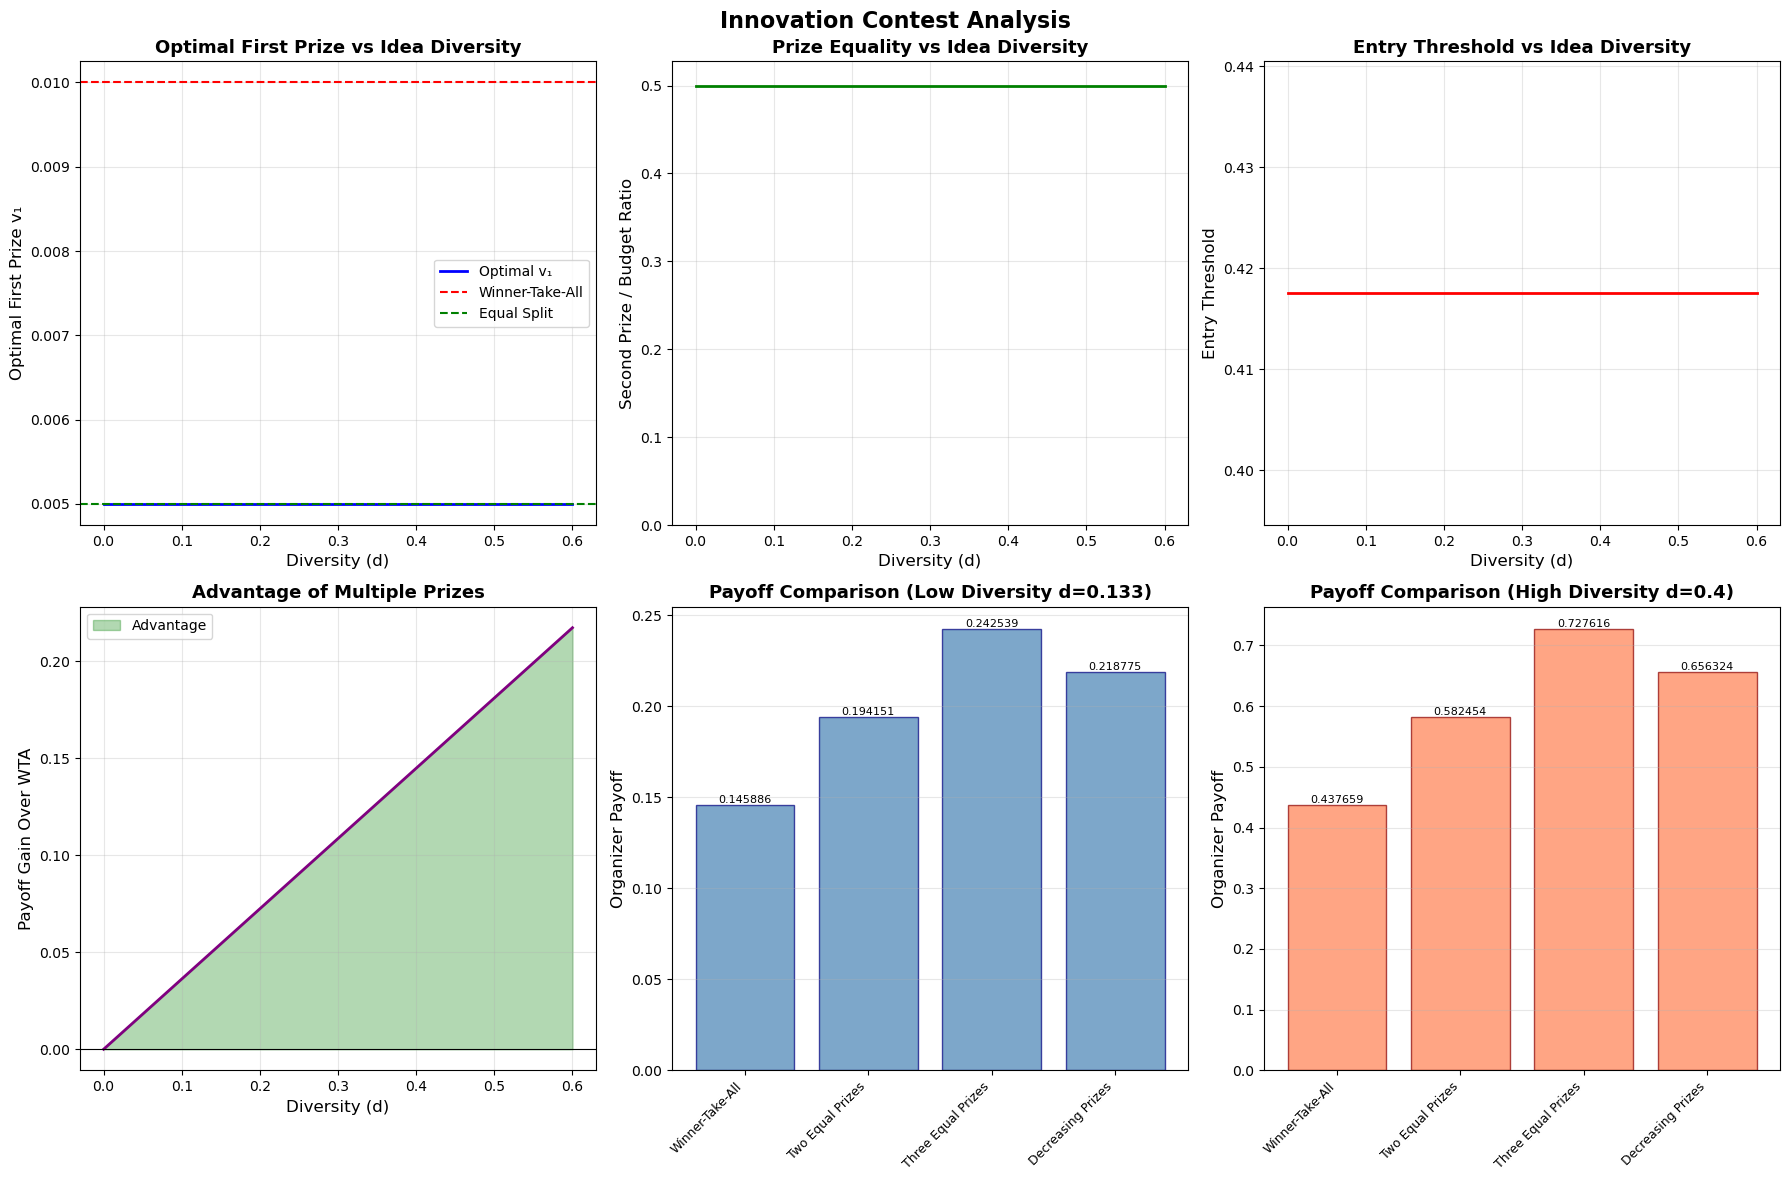


Additional Analysis: Effect of Number of Agents
Analyzing N=3...
Analyzing N=5...
Analyzing N=7...
Analyzing N=10...

  N  WTA Entry Prob  WTA Payoff  Equal Entry Prob  Equal Payoff  Gain from Equal
 3        0.683772    0.307698             0.475       0.21375        -0.093948
 5        0.437659    0.328244             0.500       0.37500         0.046756
 7        0.318708    0.334643             0.475       0.49875         0.164107
10        0.225736    0.338604             1.000       1.50000         1.161396

✓ Simulation Complete!

Key Findings:
  • Best diversity level analyzed: 0.60
  • Maximum advantage over WTA: 0.217192
  • Optimal v2/V ratio range: [0.500, 0.500]



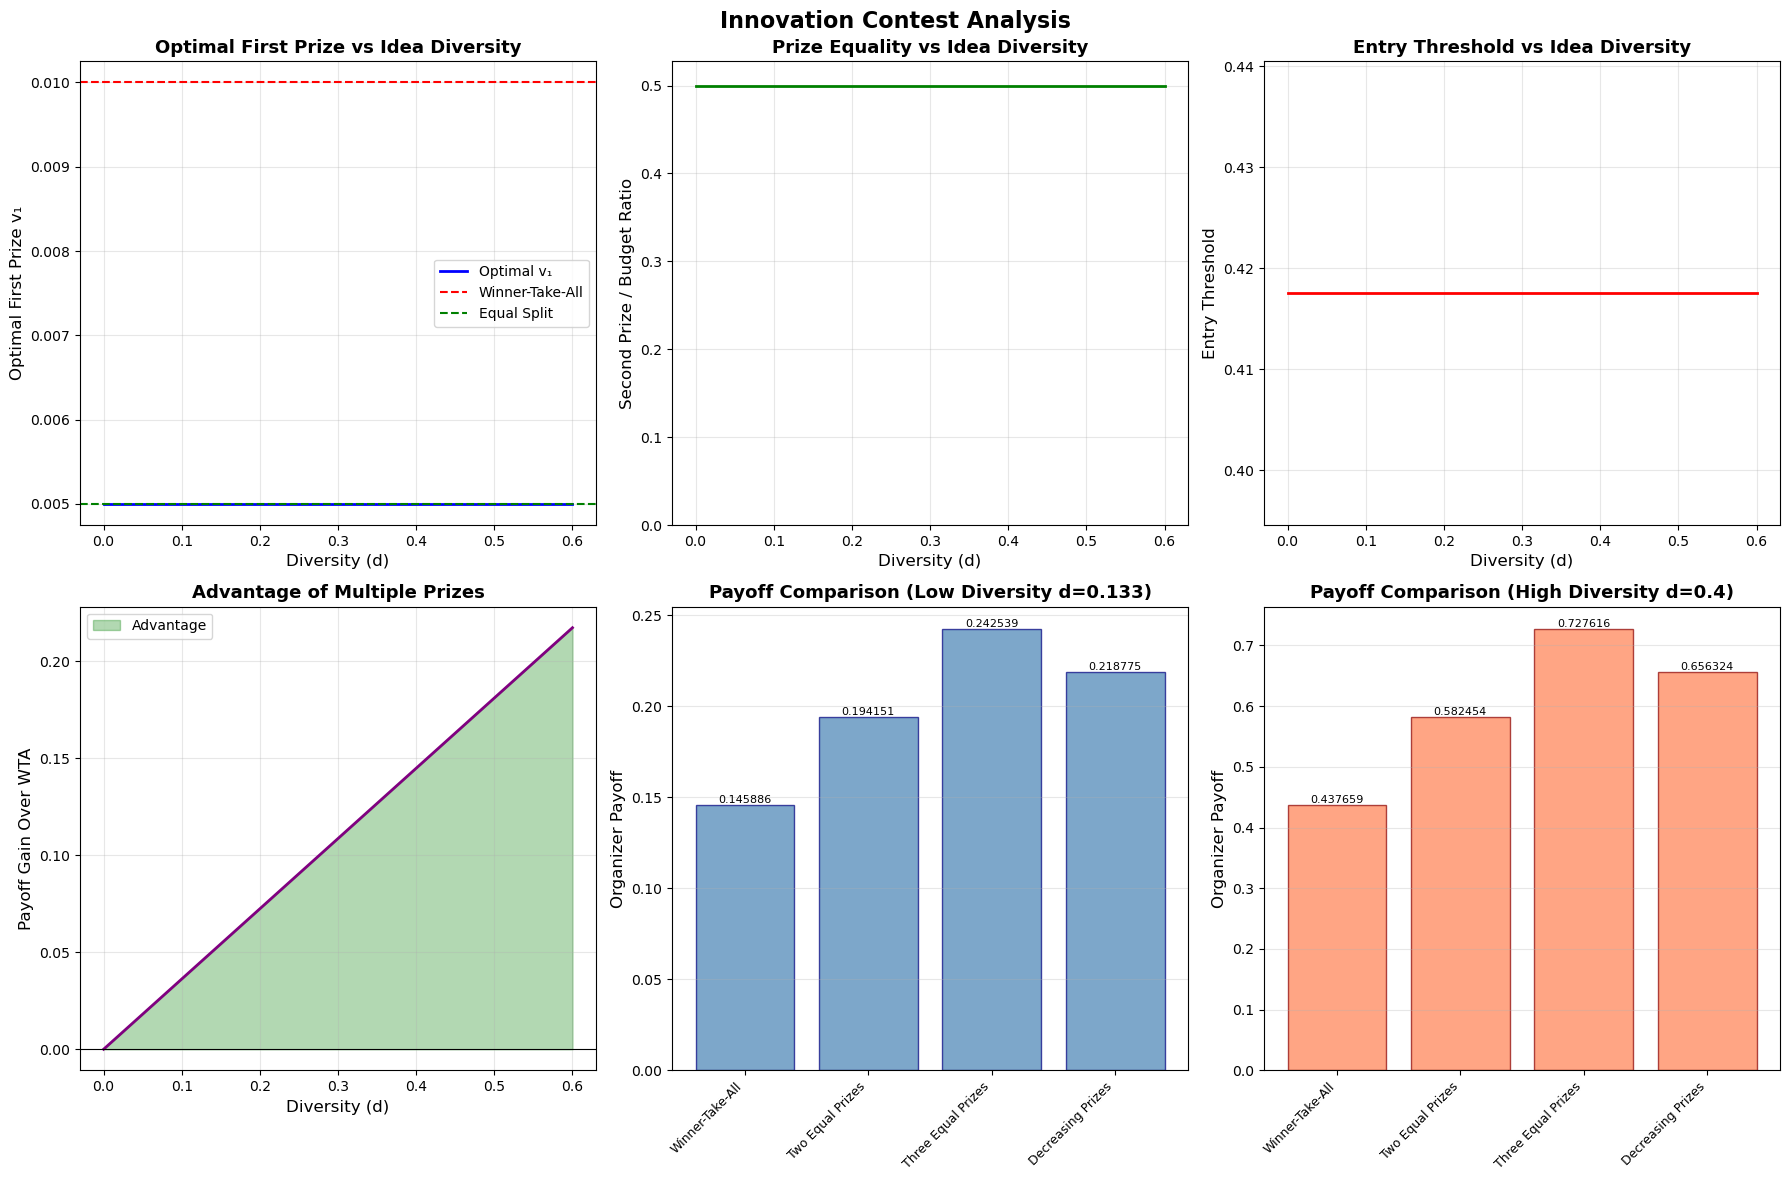

In [5]:
if __name__ == "__main__":
    
    np.random.seed(42)

    print("\n"  + "=" * 76)
    print("Starting Innovation Contest Comprehensive Analysis")
    print("=" * 80 + "\n")

    # main simulations
    df_optimal, results_low, results_high = run_comprehensive_simulation()

    # analysis for certain condition
    df_N = additional_analysis()

    print("\n" + "=" * 80)
    print("✓ Simulation Complete!")
    print("=" * 80)
    print("\nKey Findings:")
    print(f"  • Best diversity level analyzed: {df_optimal['Diversity (d)'].max():.2f}")
    print(f"  • Maximum advantage over WTA: {df_optimal['Advantage'].max():.6f}")
    print(f"  • Optimal v2/V ratio range: [{df_optimal['v2/V Ratio'].min():.3f}, {df_optimal['v2/V Ratio'].max():.3f}]")
    print("\n" + "=" * 80)
